<a href="https://colab.research.google.com/github/Katsushi-Nakanishi/quant-macro/blob/main/AssetFunction_gridsearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

In [2]:
# 効用関数を定義
def util(cons, gamma):
    return max(cons, 1e-4) ** (1.0-gamma) / (1.0-gamma)

# cos > 0 が必ず成り立たなければならない⇒1e-4とのmaxをとる

In [3]:
a_l = 0.025 # aの最小値(0にすると挙動がおかしくなる)
a_u = 1.0-0.025 # aの最大値(1にすると挙動がおかしくなる)   ←　後でいじれるように最初に書いておく。
NA = 40 # グリッド数

w_l = 0.1
w_u = 1.0
NW = 10

w = np.linspace(w_l, w_u, NW)
a = np.linspace(a_l, a_u, NA) # [0.025, 1.0]の範囲で40個のグリッドを作成
gamma = 2.0
beta = 0.985 ** 30
r = 1.025 ** 30 - 1.0

# range(1,5) = 1,2,3,4
# range(5) = range(0,5) = 0,1,2,3,4

# wの値に応じて変わるaに関する入れ物を用意
iaplus = np.zeros(NW, dtype=int) # 整数であることを明示
aplus = np.zeros(NW)

for iw in range(NW):
    reward = np.zeros(NA)  # 40個の1次元配列の入れものを用意
    for ia in range(NA):
        reward[ia] = util(w[iw]-a[ia], gamma) + beta*util((1.0+r)*a[ia], gamma)
    iaplus[iw] = np.argmax(reward) # 最大となる要素の番号を教えてくれる
    aplus[iw] = a[iaplus[iw]]

print(aplus)

[0.025      0.07371795 0.09807692 0.14679487 0.17115385 0.21987179
 0.24423077 0.29294872 0.31730769 0.36602564]


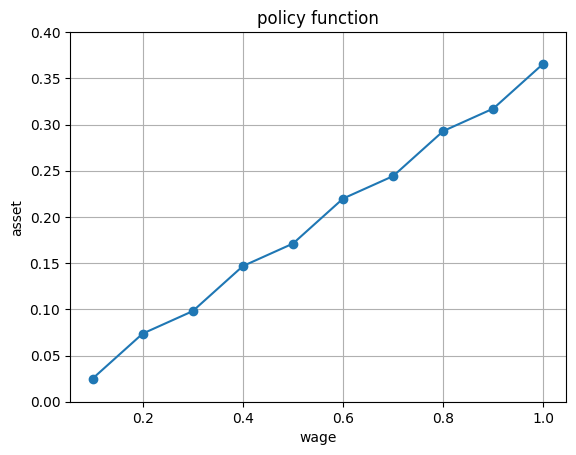

In [4]:
# 政策関数（貯蓄関数）の表示
plt.figure()
plt.plot(w, aplus, marker='o') # 各wに対する最適なasset
plt.title("policy function")
plt.xlabel("wage")
plt.ylabel("asset")
plt.ylim(0,0.4) # y軸の表示範囲
plt.grid(True)
plt.show()

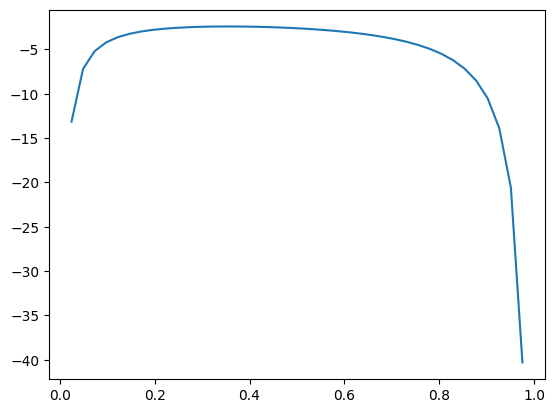

In [5]:
plt.plot(a, reward) # plot(x軸, y軸)でグラフを生成

In [6]:
# 2-period model: optimization routine

aplus = np.zeros(NW) # optimal assets for each w

for iw in range(NW): # solve for each wage grid

    def negative_value_func(x): # max value = min negative value, x = assets
        return - util(w[iw] - x, gamma) - beta*util((1.0+r)*x, gamma)

    result = minimize_scalar(negative_value_func, bounds=(a_l, w[iw])) # minimization

    aplus[iw] = result.x # optimizer

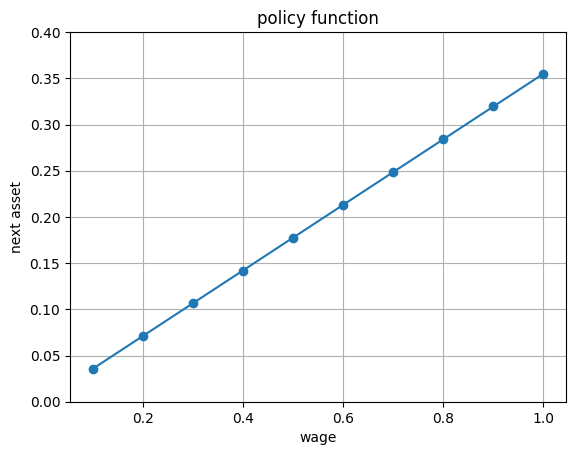

In [7]:
# figure

plt.figure()
plt.plot(w, aplus, marker='o')
plt.title("policy function")
plt.xlabel("wage")
plt.ylabel("next asset")
plt.ylim(0, 0.4)
plt.grid(True)
plt.show()

In [8]:
# 2-period model: value function iteration

v_2 = np.zeros(NA)

for ia in range(NA):
    v_2[ia] = util((1.0+r)*a[ia], gamma)

iaplus = np.zeros(NW, dtype=int) # indices (integers) of optimal assets for each w
aplus = np.zeros(NW) # optimal assets for each w

for iw in range(NW): # solve for each wage grid

    reward = np.zeros(NA) # setting reward array for each candidate asset

    for ia in range(NA): # calculate utility with the candidate assets
        reward[ia] = util(w[iw] - a[ia], gamma) + beta*v_2[ia]

    iaplus[iw] = np.argmax(reward)
    aplus[iw] = a[iaplus[iw]]

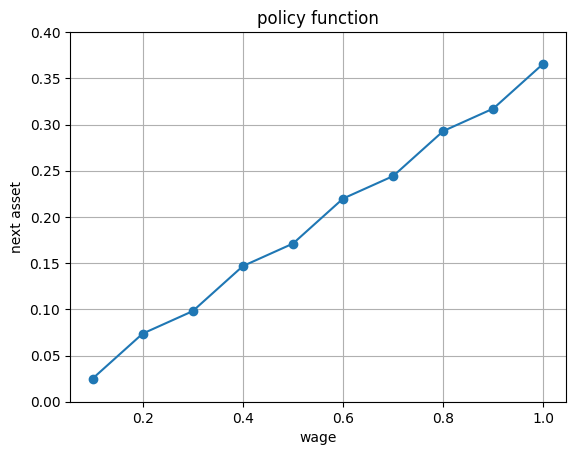

In [9]:
# figure

plt.figure()
plt.plot(w, aplus, marker='o')
plt.title("policy function")
plt.xlabel("wage")
plt.ylabel("next asset")
plt.ylim(0, 0.4)
plt.grid(True)
plt.show()

In [10]:
# linear interpolation
def linint(a_plus, a_l, a_u, NA):
    # create a grid of values between a_l and a_u
    a = np.linspace(a_l, a_u, NA)

    # a_plus(x)に一番近い a を求める式
    idx = np.argmin(np.abs(a - a_plus))

    # 一番近いaがxの左側か、右側か？
    if a_plus <= a_l:
        # xがaの最小値よりも小さい場合
        ial = 0
    elif a_plus >= a_u:
        # xがaの最小値よりも大きい場合
        ial = NA - 2
    else:
        # aが左側の点
        if a_plus - a[idx] > 0:
            ial = idx
        # aが右側の点
        else:
            ial = idx - 1
    iar = ial + 1

    # 右側の点との距離が、両側幅全体の何パーセントか
    varphi = (a[iar] - a_plus) / (a[iar] - a[ial])


    return ial, iar, varphi

In [11]:
# optimization

v_2 = np.zeros(NA)
v_2p = np.zeros(NA)

for ia in range(NA):
    v_2[ia] = util((1.0+r)*a[ia], gamma)

    v_2p[ia] = (1.0+r) * a[ia]      # V_2を変形した線形関数を用意する。

aplus = np.zeros(NW) # optimal assets for each w

for iw in range(NW): # solve for each wage grid

    def negative_value_func(x): # 最大化 ＝　マイナスの最小化, x = assets
        ial, iar, varphi = linint(x, a_l, a_u, NA) # 上のセルで関数定義

        V_help = varphi * v_2p[ial] + (1.0 - varphi) *  v_2p[iar]   # 両隣の保存点の値の加重和
        V_help = V_help ** (1.0 - gamma) / (1.0 - gamma)  # 線形関数から元の効用関数に戻す変換を行う。
        return - util(w[iw] - x, gamma) - beta * V_help

    result = minimize_scalar(negative_value_func, bounds=(a_l, w[iw])) # minimization

    aplus[iw] = result.x # optimizer

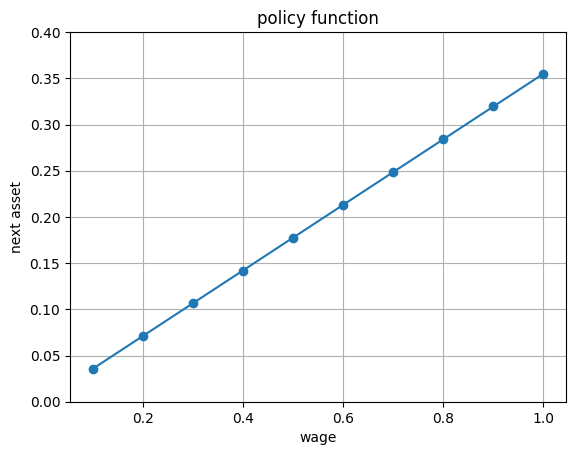

In [12]:
# figure

plt.figure()
plt.plot(w, aplus, marker='o')
plt.title("policy function")
plt.xlabel("wage")
plt.ylabel("next asset")
plt.ylim(0, 0.4)
plt.grid(True)
plt.show()